# K-Means Cluster Analysis

This is an assignment for week 4 of the 'Machine Learning for Data Analysis' course by Wesleyan University.

A k-means cluster analysis was conducted to identify underlying subgroups of countries based on their similarity in macroeconomic indicators. 

Categorical predictors include binary variables for WTO membership and landlocked-'ness' of a country. Quantitative predictor variables include income level of a country measured in GDP per capita, the score of 'Ease of doing business', the average applied tariff and economical remoteness. 

All data were collected for 2017.
All predictor variables were standardized to have a mean of zero and a standard deviation of one.

## Prepare the dataset 

In [165]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi 

In [166]:
# Download prepared csv file
data = pd.read_csv('openness_df.csv')

In [167]:
data.sample(5)

,country,year,gdp,gdp_ppc,imports,exports,population,business_ease,code,region,tariff,wto_status,landlocked,remoteness,openness
114,Lesotho,2017,2.565352e+09,1226.612630,2.157490e+09,1.055693e+09,2091412.0,58.56005,LSO,Sub-Saharan Africa,12.020633,Member,1,NaN,1.252531
201,Uganda,2017,2.599503e+10,631.522720,6.578802e+09,4.729743e+09,41162465.0,57.87464,UGA,Sub-Saharan Africa,11.259265,Member,1,2.808672e+10,0.435027
20,"Bahamas, The",2017,1.215040e+10,31827.242699,5.000200e+09,4.192100e+09,381761.0,58.61968,BHS,Latin America & Caribbean,19.157399,Observer,0,1.924696e+10,0.756543
109,Liberia,2017,3.285455e+09,698.701764,3.242931e+09,7.978462e+08,4702228.0,43.58222,LBR,Sub-Saharan Africa,NaN,Member,0,4.519561e+09,1.229899
209,Virgin Islands (U.S.),2017,3.855000e+09,35938.024388,3.029000e+09,2.795000e+09,107268.0,NaN,VIR,Latin America & Caribbean,NaN,No perticipation,0,NaN,1.510765


In [168]:
# Clean the data
data = data[['gdp_ppc','business_ease','landlocked','remoteness','wto_status','tariff','openness']]
data = data[data['remoteness'] > 0]
data.dropna(inplace=True)

# Bin WTO status into two categories
data["wto_status"] = data["wto_status"].replace({'Member': 1, 'Observer': 0, 'No perticipation': 0})

Trying to standardize predictors, I've got the error 'UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.' So I've decided to convert imports, exports and remoteness to millions.

In [169]:
# Set values in millions
data['gdp_ppc_m'] = data['gdp_ppc'] / 1000000000
data['remoteness_m'] = data['remoteness'] / 1000000000

In [170]:
# Subset clustering variables
cluster = data[['gdp_ppc_m','business_ease','landlocked','remoteness_m','wto_status','tariff']]
cluster.describe()

,gdp_ppc_m,business_ease,landlocked,remoteness_m,wto_status,tariff
count,1.280000e+02,128.000000,128.000000,128.000000,128.000000,128.000000
mean,1.102304e-05,61.003450,0.226562,873.034649,0.890625,8.588206
std,1.676600e-05,12.221347,0.420252,3169.389920,0.313335,4.888276
min,2.929976e-07,32.351740,0.000000,0.483795,0.000000,0.000000
25%,1.551603e-06,52.960030,0.000000,11.962895,1.000000,5.248021
50%,4.190149e-06,60.444595,0.000000,49.775052,1.000000,7.828432
75%,1.049209e-05,69.049845,0.000000,264.630281,1.000000,11.187245
max,8.045005e-05,87.022130,1.000000,27741.072241,1.000000,32.303855


In [171]:
# standardize clustering variables to have mean=0 and sd=1
clustervar=cluster.copy()
clustervar['gdp_ppc_m']=preprocessing.scale(clustervar['gdp_ppc_m'].astype('float64'))
clustervar['business_ease']=preprocessing.scale(clustervar['business_ease'].astype('float64'))
clustervar['landlocked']=preprocessing.scale(clustervar['landlocked'].astype('float64'))
clustervar['remoteness_m']=preprocessing.scale(clustervar['remoteness_m'].astype('float64'))
clustervar['wto_status']=preprocessing.scale(clustervar['wto_status'].astype('float64'))
clustervar['tariff']=preprocessing.scale(clustervar['tariff'].astype('float64'))

## Choosing the number of clusters

In [172]:
# split data into train and test sets
clus_train, clus_test = train_test_split(clustervar, test_size=.3, random_state=123)

# k-means cluster analysis for 1-9 clusters                                                           
clusters=range(1,10)
meandist=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(clus_train)
    clusassign=model.predict(clus_train)
    meandist.append(sum(np.min(cdist(clus_train, model.cluster_centers_, 'euclidean'), axis=1)) / clus_train.shape[0])

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

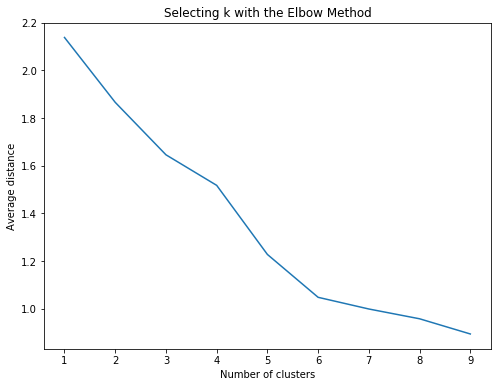

In [173]:
plt.figure(figsize=(8,6))
plt.plot(clusters, meandist)
plt.xlabel('Number of clusters')
plt.ylabel('Average distance')
plt.title('Selecting k with the Elbow Method')

### Visualizing different clusters solutions

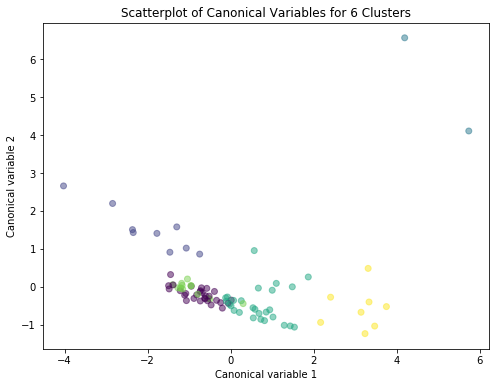

In [174]:
# Try 6 cluster solution
model6=KMeans(n_clusters=6)
model6.fit(clus_train)
clusassign=model6.predict(clus_train)

pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)

plt.figure(figsize=(8,6))
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model6.labels_, alpha=0.5)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 6 Clusters')
plt.show()

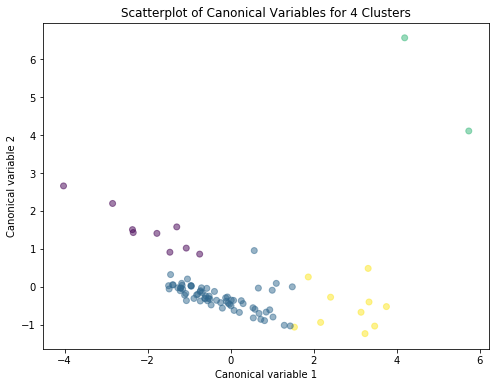

In [175]:
# Try 4 cluster solution
model4=KMeans(n_clusters=4)
model4.fit(clus_train)
clusassign=model6.predict(clus_train)

pca_2 = PCA(2)
plot_columns = pca_2.fit_transform(clus_train)

plt.figure(figsize=(8,6))
plt.scatter(x=plot_columns[:,0], y=plot_columns[:,1], c=model4.labels_, alpha=0.5)
plt.xlabel('Canonical variable 1')
plt.ylabel('Canonical variable 2')
plt.title('Scatterplot of Canonical Variables for 4 Clusters')
plt.show()

### Findings


Scatterplots for 6 clusters contain a group of observation located between 0 and -1 on the y-axis and -2 and 2 on the x-axis that was densely packed. Those clusters were highly correlated with each other and within-cluster variance was relatively low. 
Dividing observation onto 4 clusters show better separation, so this is the model that will be interpreted. 

### Interpretation of the Three Cluster Solution

In [176]:
# create a unique identifier variable from the index for the 
# cluster training data to merge with the cluster assignment variable
clus_train.reset_index(level=0, inplace=True)
# create a list that has the new index variable
cluslist=list(clus_train['index'])
# create a list of cluster assignments
labels=list(model4.labels_)
# combine index variable list with cluster assignment list into a dictionary
newlist=dict(zip(cluslist, labels))

# convert newlist dictionary to a dataframe
newclus=pd.DataFrame.from_dict(newlist, orient='index')

# rename the cluster assignment column
newclus.columns = ['cluster']

# now do the same for the cluster assignment variable
# create a unique identifier variable from the index for the 
# cluster assignment dataframe 
# to merge with cluster training data
newclus.reset_index(level=0, inplace=True)
# merge the cluster assignment dataframe with the cluster training variable dataframe
# by the index variable
merged_train=pd.merge(clus_train, newclus, on='index')
merged_train.head(n=100)
# cluster frequencies
merged_train.cluster.value_counts()

1    68
3    10
0     9
2     2
Name: cluster, dtype: int64

In [177]:
# Calculate clustering variable means by cluster
clustergrp = merged_train.groupby('cluster').mean()
print ("Clustering variable means by cluster")
print(clustergrp)

Clustering variable means by cluster
              index  gdp_ppc_m  business_ease  landlocked  remoteness_m  \
cluster                                                                   
0         66.333333  -0.290127      -0.448195    0.520493     -0.269912   
1        112.602941  -0.326220      -0.110304   -0.049402     -0.171593   
2        120.000000   1.397295       1.100261   -0.541229      7.319269   
3         83.700000   2.617142       1.450540   -0.302342      0.376824   

         wto_status    tariff  
cluster                        
0         -2.853569  1.294386  
1          0.350438  0.052379  
2          0.350438 -0.986801  
3          0.350438 -1.155200  


### Interpretation

The first cluster contains 9 countries that have second lowest income levels, but they are the worst in terms of ease of doing business, they contain the largest proportion of landlocked countries, they have the least proportion of the WTO members and the highest tariffs. Nevertheless, they are closest to their trading partners.

The second cluster contains 68 poorest countries that are in the second-lowest position for the most indicators: they have the second-lowest ease of doing business and economical remoteness, second-highest applied tariffs and second-highest proportion of landlocked countries. However, they contain the same proportion of WTO members as the third and fourth clusters.

The third cluster contains 2 countries that have the second-highest income levels, ease of doing business, second-lowest tariffs. They are the least landlocked counties and they are located farthest to their trading partners.

The third cluster contains 10 richest countries. They are easiest in doing business in and apply the lowest tariffs. They are second closest to their trading partners and contain the second least landlocked countries.

## Trade Openness Analysis

Validating clusters in training data by examining cluster differences in tarde openness using ANOVA.

In [178]:
# Merge Opennes with clustering variables and cluster assignment data 
data_o = data['openness']
# split Opennes data into train and test sets

o_train, o_test = train_test_split(data_o, test_size=.3, random_state=123)

o_train1=pd.DataFrame(o_train)
o_train1.reset_index(level=0, inplace=True)

merged_train_all=pd.merge(o_train1, merged_train, on='index')

sub1 = merged_train_all[['openness', 'cluster']].dropna()

In [184]:
gpamod = smf.ols(formula='openness ~ C(cluster)', data=sub1).fit()
gpamod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               openness   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.163
Method:                 Least Squares   F-statistic:                     6.700
Date:                Tue, 02 Jun 2020   Prob (F-statistic):           0.000410
Time:                        18:15:43   Log-Likelihood:                -58.778
No. Observations:                  89   AIC:                             125.6
Df Residuals:                      85   BIC:                             135.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.6878      0.160      4.305      0.000       0.370       1.005
C(cluster)[T.1]     0.0964      0.170      0.567      0.572      -0.242       0.434
C(cluster)[T.2]    -0.3613      0.375     -0.964      0.338      -1.106       0.384
C(cluster)[T.3]     0.7580      0.220      3.442      0.001       0.320       1.196
==============================================================================
Omnibus:                       53.947   Durbin-Watson:                   1.943
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              237.222
Skew:                           1.914   Prob(JB):                     3.08e-52
Kurtosis:                      10.022   Cond. No.                         10.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Means for Trade Openness by Cluster

In [187]:
sub1.groupby('cluster').mean()

,openness
cluster,
0,0.687755
1,0.784146
2,0.326460
3,1.445709


#### Standard deviations for Trade Openness by cluster

In [186]:
sub1.groupby('cluster').std()

,openness
cluster,
0,0.270746
1,0.331336
2,0.077834
3,1.134078


In [188]:
mc1 = multi.MultiComparison(sub1['openness'], sub1['cluster'])
res1 = mc1.tukeyhsd()
res1.summary()

group1,group2,meandiff,lower,upper,reject
0,1,0.0964,-0.3491,0.5419,False
0,2,-0.3613,-1.3431,0.6206,False
0,3,0.758,0.1809,1.335,True
1,2,-0.4577,-1.3588,0.4434,False
1,3,0.6616,0.2362,1.0869,True
2,3,1.1192,0.1464,2.0921,True


## Conclusion 

F-statistics shows that clusters varied significantly on trade openness. Examination of the means shows that the richest, easiest to do business in countries had the highest trade openness. The second higher trade openness has countries that were the poorest. We can hypothesize that those countries are not benefiting from free trade, and maybe can not stand to global competition. 

However, the Tukey test shows that a significant difference was observed only between the first and third groups (the second-highest and second-lowest in income levels), between the second and the fourth group (poorest and richest) and between third and fourth groups (the second-highest and the richest).